### Import Required Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
import string
import re


sns.set()

### Load the Dataset

In [2]:
df = pd.read_csv('merged_dataset_deep.csv')
df

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5
...,...,...
607443,cheap product its not a microwave safe,2
607444,it broked when the food is in on itnot one pla...,2
607445,full plate size is too small,2
607446,plates size is small bowl is too smallquality ...,2


### Exploratory Data Analysis

In [3]:
df['Score'].value_counts()

Score
5    363122
4     80655
3     64079
1     52268
2     47324
Name: count, dtype: int64

In [4]:
df.columns

Index(['Text', 'Score'], dtype='object')

In [5]:
df.rename(columns={'Text':'review_text','Score':'Rating'}, inplace=True)

In [6]:
df.columns

Index(['review_text', 'Rating'], dtype='object')

In [7]:
df.shape

(607448, 2)

In [8]:
df.isnull().any()

review_text     True
Rating         False
dtype: bool

In [9]:
df.isnull().sum()

review_text    9
Rating         0
dtype: int64

In [10]:
df.dropna(subset=['review_text'], inplace=True)

In [11]:
df.isnull().sum()

review_text    0
Rating         0
dtype: int64

In [12]:
df.describe()

,Rating
count,607439.000000
mean,4.078372
std,1.335345
min,1.000000
25%,3.000000
50%,5.000000
75%,5.000000
max,5.000000


### Checking  for Duplicate values

In [13]:
df.duplicated().sum()

176774

In [14]:
# drop duplicate values
df.drop_duplicates(inplace=True)

In [15]:
df['Rating'].value_counts()

Rating
5    250745
4     56074
3     51205
2     36361
1     36280
Name: count, dtype: int64

### Remove Conflicting Reviews (Same text, different ratings)

In [16]:
# Step 1: Check how many reviews have conflicting ratings
conflict_counts = (
    df.groupby('review_text')['Rating']
      .nunique()
      .reset_index()
      .rename(columns={'Rating': 'unique_ratings'})
)

In [17]:
# Step 2: Get texts that have more than 1 unique rating
conflicting_reviews = conflict_counts[conflict_counts['unique_ratings'] > 1]['review_text']

In [18]:
# Filter original df for only conflicting reviews
conflict_df = df[df['review_text'].isin(conflicting_reviews)]

# Group by reviewText to see all associated ratings
conflict_summary = conflict_df.groupby('review_text')['Rating'].unique().reset_index()

# Optional: Show a few rows
conflict_summary.head(10)

,review_text,Rating
0,#NAME?,"[3, 2]"
1,"<a href=""http://www.amazon.com/gp/product/B004...","[3, 4]"
2,A Ming Dynasty (AD 1368 - 1644) creation belie...,"[5, 4]"
3,"A few years ago, my cat was diagnosed with foo...","[5, 4]"
4,After trying both the Chipotle as well as the ...,"[5, 4]"
5,Any of us who grew up during the U.S. space ag...,"[4, 5]"
6,Before the details: The Planters big nut bars...,"[5, 4]"
7,Bought this coffee in Europe when I was travel...,"[4, 5]"
8,Buffalo Bills Premium Snacks<br /><br />I real...,"[3, 5]"
9,"Coffee drinks aren't carbonated, so it's odd t...","[2, 1]"


In [19]:
# Step 3: Remove those reviews from the main DataFrame
df_cleaned = df[~df['review_text'].isin(conflicting_reviews)].copy()

In [20]:
# Result: no same review text with different ratings
print(f"Original dataset size: {len(df)}")
print(f"Cleaned dataset size: {len(df_cleaned)}")

Original dataset size: 430665
Cleaned dataset size: 430456


In [21]:
df_cleaned['Rating'].value_counts()

Rating
5    250682
4     56009
3     51167
2     36332
1     36266
Name: count, dtype: int64

In [22]:
# Confirm no conflicts remain
check = df_cleaned.groupby('review_text')['Rating'].nunique()
print("Max unique ratings per reviewText:", check.max())

Max unique ratings per reviewText: 1


## Data Visualisation
#### Rating distribuion before balancing

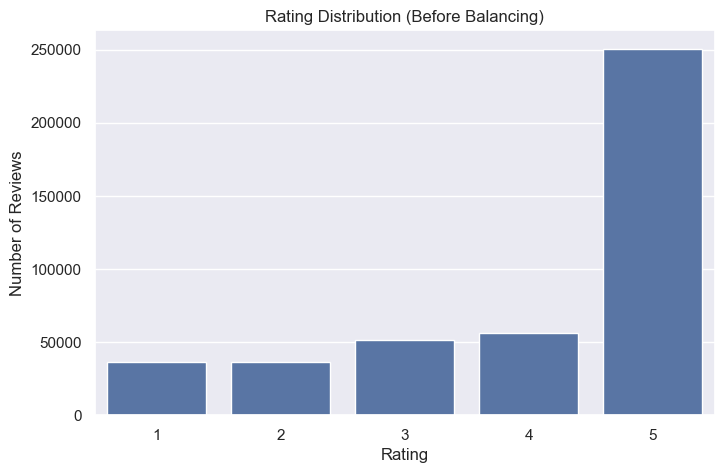

In [23]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Rating', data=df_cleaned)
plt.title("Rating Distribution (Before Balancing)")
plt.xlabel("Rating")
plt.ylabel("Number of Reviews")
plt.show()

### Pie chart showing the rating percentage distribution

In [24]:
rating_counts = df_cleaned['Rating'].value_counts().sort_index()

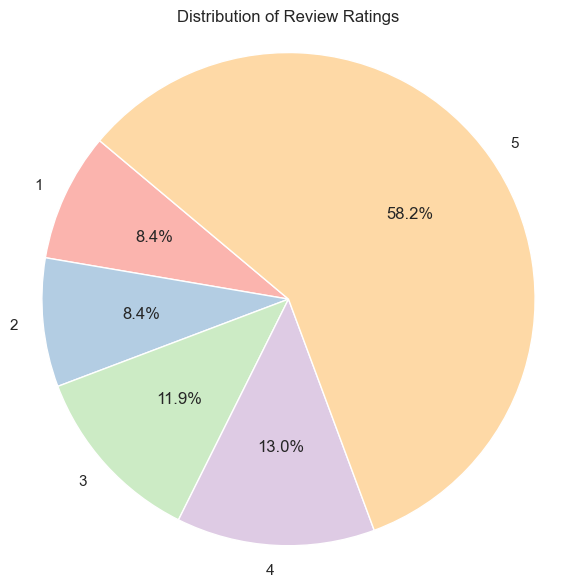

In [25]:
# Labels and sizes
labels = rating_counts.index.astype(str)
sizes = rating_counts.values

# Plot pie chart
plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Pastel1.colors)
plt.title('Distribution of Review Ratings')
plt.axis('equal')  # Equal aspect ratio makes the pie chart circular
plt.show()

###  Clean Review Text (Punctuation, Spaces, Stopwords)

In [26]:
# 1. Pre-split cleaning: punctuation, emojis, spaces
import re
import string

def basic_clean(text):
    text = str(text).lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)         # Remove URLs
    text = re.sub(r'<.*?>', '', text)                           # Remove HTML tags
    text = re.sub(r'[^\x00-\x7F]', '', text)                    # Remove non-ASCII (emojis etc.)
    text = re.sub(rf"[{re.escape(string.punctuation)}]", '', text)  # Remove all punctuation
    text = re.sub(r'\s+', ' ', text).strip()                    # Normalize whitespace
    return text


In [27]:
df_cleaned['review_text'] = df_cleaned['review_text'].apply(basic_clean)

In [28]:
df_cleaned.to_csv("cleaned_reviews.csv", index=False)

In [29]:
df_cleaned = pd.read_csv('cleaned_reviews.csv')

In [30]:
print(df_cleaned.columns)


Index(['review_text', 'Rating'], dtype='object')


In [31]:
print(df_cleaned['review_text'].head())


0    i have bought several of the vitality canned d...
1    product arrived labeled as jumbo salted peanut...
2    this is a confection that has been around a fe...
3    if you are looking for the secret ingredient i...
4    great taffy at a great price there was a wide ...
Name: review_text, dtype: object


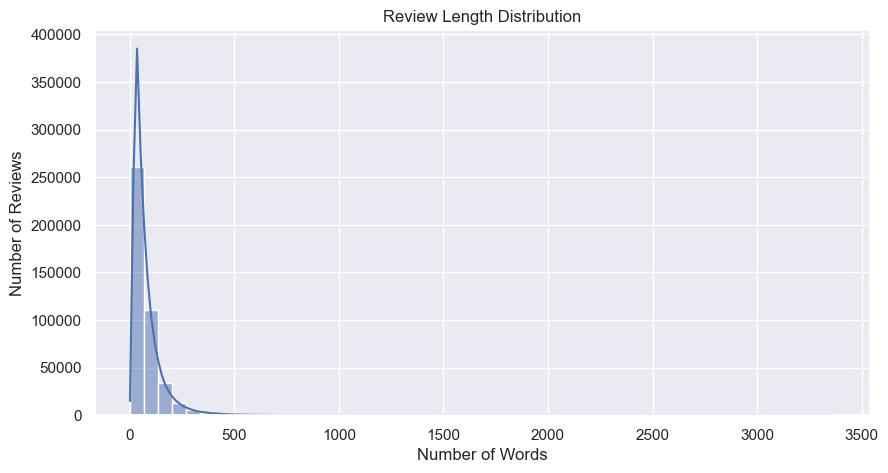

In [32]:
df_cleaned['review_length'] = df_cleaned['review_text'].str.split().str.len()

plt.figure(figsize=(10, 5))
sns.histplot(data=df_cleaned, x='review_length', bins=50, kde=True)
plt.title("Review Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Number of Reviews")
plt.show()

In [33]:
df_filtered = df_cleaned[
    (df_cleaned['review_length'] > 3) & 
    (df_cleaned['review_length'] <= 500)
]

In [34]:
print("Before filtering:", len(df_cleaned))
print("After filtering:", len(df_filtered))

Before filtering: 430456
After filtering: 427624


In [35]:
df_filtered['Rating'].value_counts()

Rating
5    249959
4     55725
3     50619
1     36131
2     35190
Name: count, dtype: int64

In [36]:
df_filtered.duplicated().sum()

503

In [37]:
#drop duplicated now
df_filtered = df_filtered.drop_duplicates(subset='review_text', keep='first').reset_index(drop=True)
df_filtered['Rating'].value_counts()

Rating
5    249661
4     55649
3     50567
1     36045
2     35170
Name: count, dtype: int64

In [38]:
df_filtered1 = df_cleaned[
    (df_cleaned['review_length'] > 500)]
df_filtered1['Rating'].value_counts()

Rating
5    702
3    507
4    282
2    263
1    133
Name: count, dtype: int64

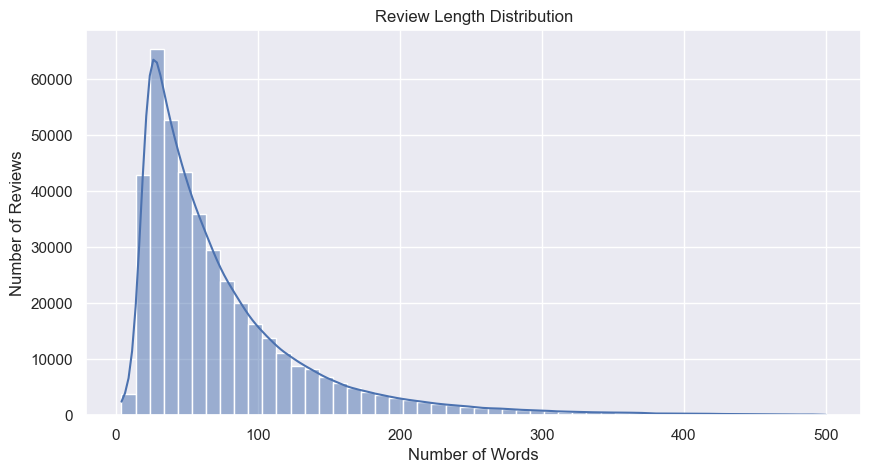

In [39]:
df_cleaned['review_length'] = df_filtered['review_text'].str.split().str.len()

plt.figure(figsize=(10, 5))
sns.histplot(data=df_cleaned, x='review_length', bins=50, kde=True)
plt.title("Review Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Number of Reviews")
plt.show()

In [40]:
df_balanced = pd.concat([
    df_filtered[df_filtered['Rating'] == 1].sample(20000, random_state=42),
    df_filtered[df_filtered['Rating'] == 2].sample(20000, random_state=42),
    df_filtered[df_filtered['Rating'] == 3].sample(20000, random_state=42),
    df_filtered[df_filtered['Rating'] == 4].sample(20000, random_state=42),
    df_filtered[df_filtered['Rating'] == 5].sample(20000, random_state=42),
])

In [41]:
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [43]:
df_balanced.to_csv("deep_balanced_dataset.csv", index=False)

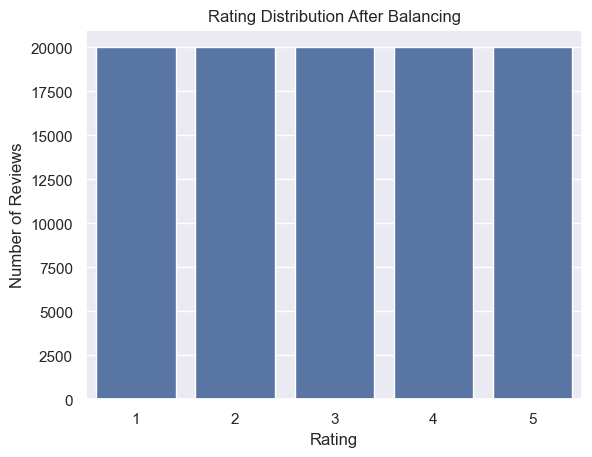

In [45]:
sns.countplot(x='Rating', data=df_balanced)
plt.title("Rating Distribution After Balancing")
plt.xlabel("Rating")
plt.ylabel("Number of Reviews")
plt.show()

In [46]:
rating_counts = df_balanced['Rating'].value_counts().sort_index()

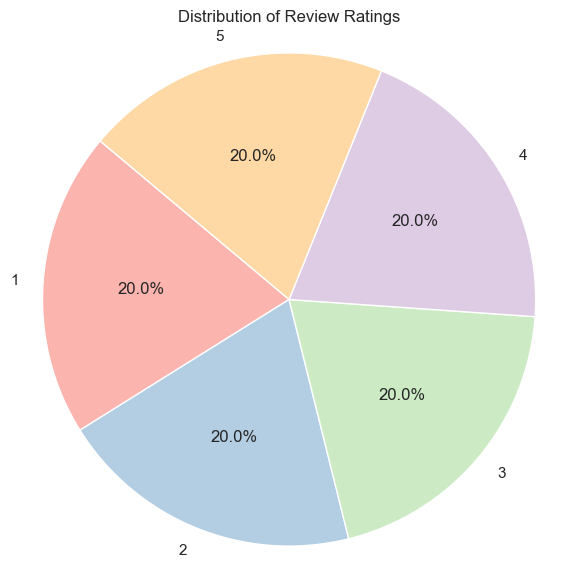

In [47]:
# Labels and sizes
labels = rating_counts.index.astype(str)
sizes = rating_counts.values

# Plot pie chart
plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Pastel1.colors)
plt.title('Distribution of Review Ratings')
plt.axis('equal')  # Equal aspect ratio makes the pie chart circular
plt.show()

In [48]:
used_balanced = df_balanced.index
df_remaining = df_filtered.drop(index=used_balanced, errors='ignore')

In [49]:
print("Total cleaned dataset:", len(df_filtered))
print("Balanced dataset:", len(df_balanced))
print("Remaining dataset after exclusion:", len(df_filtered.drop(index=df_balanced.index, errors='ignore')))

Total cleaned dataset: 427092
Balanced dataset: 100000
Remaining dataset after exclusion: 327092


In [52]:
print("Balanced dataset size:", len(df_balanced))
print("Unique review_texts in balanced:", df_balanced['review_text'].nunique())

Balanced dataset size: 100000
Unique review_texts in balanced: 100000


In [53]:
print("Balanced unique reviewText count:", df_balanced['review_text'].nunique())
print("Full unique reviewText count:", df_filtered['review_text'].nunique())

Balanced unique reviewText count: 100000
Full unique reviewText count: 427092


In [54]:
print(df_balanced['review_text'].head(10))


0    this is a great alternative to regular brown a...
1    been a long time since i had a fresh tootsie r...
2    if these bars are made in china do we really k...
3    these are a better brand than some other energ...
4    the hemp protein is not only a great buy but i...
5    this is a must have for any survivalist to cur...
6    big red is the best thing invented i have to h...
7    im so happy to see this on amazon i used to bu...
8    gluten free but even if you dont care about gl...
9    great disposable stylus dont expect long lasti...
Name: review_text, dtype: object


In [55]:
#  Define target class counts for imbalance
target_counts = {
    1: 10000,
    2: 15000,
    3: 25000,
    4: 30000,
    5: 20000
}

# Sample from remaining dataset based on distribution
df_imbalanced = pd.DataFrame()

for rating, count in target_counts.items():
    subset = df_remaining[df_remaining['Rating'] == rating]
    sampled = subset.sample(n=count, random_state=42)
    df_imbalanced = pd.concat([df_imbalanced, sampled], axis=0)

#  Shuffle final imbalanced dataset
df_imbalanced = df_imbalanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Step 7: Save to CSV
df_imbalanced.to_csv("deep_imbalanced_dataset.csv", index=False)

# Optional: Check counts
print("Imbalanced class distribution:\n", df_imbalanced['Rating'].value_counts())


Imbalanced class distribution:
 Rating
4    30000
3    25000
5    20000
2    15000
1    10000
Name: count, dtype: int64


In [59]:
df_imbalanced.shape

(100000, 3)

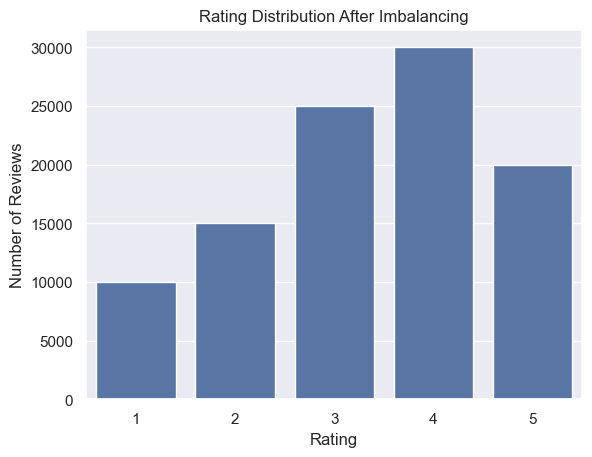

In [60]:
sns.countplot(x='Rating', data=df_imbalanced)
plt.title("Rating Distribution After Imbalancing")
plt.xlabel("Rating")
plt.ylabel("Number of Reviews")
plt.show()

In [62]:
rating_counts_imbalanced = df_imbalanced['Rating'].value_counts().sort_index()

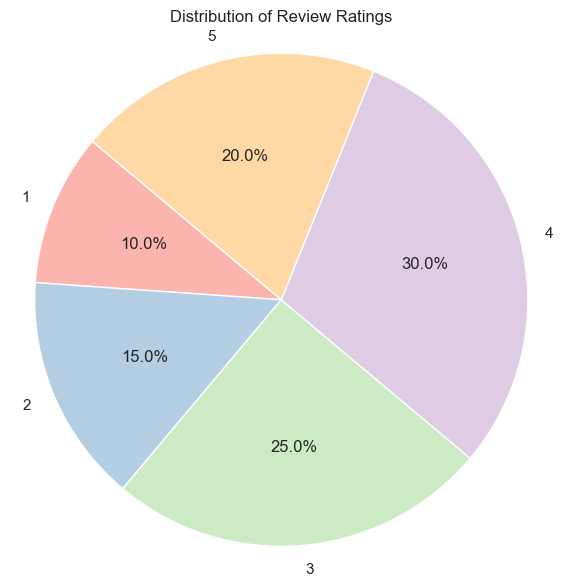

In [63]:
# Labels and sizes
labels = rating_counts_imbalanced.index.astype(str)
sizes = rating_counts_imbalanced.values

# Plot pie chart
plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Pastel1.colors)
plt.title('Distribution of Review Ratings')
plt.axis('equal')  # Equal aspect ratio makes the pie chart circular
plt.show()

In [66]:
all_in = df_balanced.isin(df_imbalanced).all().all()
print("All rows in balanced exist in imbalanced:", all_in)

All rows in balanced exist in imbalanced: False
